In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os
import time
from dataloader import preprocess_data, construct_datasets

In [2]:
train_data = preprocess_data(pd.read_csv(r'..\dat\walks\random_walk_600min.csv')).dropna()
val_data = preprocess_data(pd.read_csv(r'..\dat\walks\random_walk_300min.csv')).dropna()
test_data = preprocess_data(pd.read_csv(r'..\dat\walks\random_walk_180min.csv')).dropna()

creep_data = preprocess_data(pd.read_csv(r'..\dat\creep\random_walk_30min_pause30at30min_15.csv'))

columns_input = ['finestep_norm', 'step_diff', 'step_60rsum_exp', 'step_300rsum_exp', 'c_mean_lag10', 'c_mean_10rmean']
columns_output = ['c_mean_norm']
X_train, y_train, X_val, y_val, X_test, y_test = construct_datasets(train_data, val_data, test_data, columns_input, columns_output)

In [3]:
BATCHSIZE = 128
def get_dataloader():
    # Load the FashionMNIST dataset.
    train_loader = torch.utils.data.DataLoader(
        TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32)),
        batch_size=BATCHSIZE,
        shuffle=True,
    )
    valid_loader = torch.utils.data.DataLoader(
        TensorDataset(torch.tensor(X_val.values, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32)),
        batch_size=BATCHSIZE,
        shuffle=False,
    )
    test_loader = torch.utils.data.DataLoader(
        TensorDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32)),
        batch_size=BATCHSIZE,
        shuffle=False,
    )
    return train_loader, valid_loader, test_loader

In [4]:
def train_epoch(train_loader, model, criterion, optimizer):
    model.train()
    model.zero_grad()
    train_loss = 0
    for i, (X, y) in enumerate(train_loader):
        X, y = X.cuda(), y.cuda()
        y_pred = model(X)
        loss = criterion(y_pred[0], y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    return train_loss / len(train_loader)

def eval_epoch(valid_loader, model, criterion):
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for i, (X, y) in enumerate(valid_loader):
            X, y = X.cuda(), y.cuda()
            y_pred = model(X)
            loss = criterion(y_pred[0], y)
            valid_loss += loss.item()
    return valid_loss / len(valid_loader)

def train_model(model, criterion, optimizer, train_loader, valid_loader, n_epochs):
    for epoch in range(n_epochs):
        start_time = time.time()
        train_loss = train_epoch(train_loader, model, criterion, optimizer)
        valid_loss = eval_epoch(valid_loader, model, criterion)
        secs = int(time.time() - start_time)
        mins = secs / 60
        secs = secs % 60
        print('Epoch: %d' % (epoch + 1), " | time in %d minutes, %d seconds" % (mins, secs))
        print(f'\tLoss: {train_loss:.4f}(train)\t|\tLoss: {valid_loss:.4f}(valid)')
    return model

train_loader, valid_loader, test_loader = get_dataloader()

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, num_layers, hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=len(columns_input), hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [65]:
import optuna
from optuna.trial import TrialState
def define_model(trial):
    num_layers = trial.suggest_int("n_layers", 1, 2)
    hidden_size = trial.suggest_int("hidden_size", 4, 64)
    model = LSTMModel(num_layers, hidden_size)
    return model

def objective(trial):
    model = define_model(trial).cuda()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(10):
        model.train()
        mae = 0
        total_preds = []
        total_targets = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_preds.append(y_pred.cpu().detach().numpy())
            total_targets.append(y_batch.cpu().detach().numpy())

        mae = np.mean(np.abs(np.concatenate(total_preds) - np.concatenate(total_targets)))
        
        # mse = np.sqrt(mse / len(train_loader))
        # # Validation
        # model.eval()
        # with torch.no_grad():
        #     test_rmse = 0
        #     for X_batch, y_batch in valid_loader:
        #         y_pred = model(X_batch.cuda()).cpu()
        #         loss = criterion(y_pred, y_batch)
        #         test_rmse += loss.item()
        #     test_rmse = np.sqrt(test_rmse / len(valid_loader))
        trial.report(mae, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
        #print("Epoch %d:, test RMSE %.4f" % (epoch, test_rmse))
    return mae


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10, timeout=600)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-05-27 15:33:08,285] A new study created in memory with name: no-name-54e4b423-8bd9-41c5-b037-1db426ffe02b
[I 2024-05-27 15:34:37,140] Trial 0 finished with value: 0.0028072381392121315 and parameters: {'n_layers': 1, 'hidden_size': 29}. Best is trial 0 with value: 0.0028072381392121315.
[I 2024-05-27 15:36:05,828] Trial 1 finished with value: 0.0029373334255069494 and parameters: {'n_layers': 1, 'hidden_size': 21}. Best is trial 0 with value: 0.0028072381392121315.
[I 2024-05-27 15:37:35,347] Trial 2 finished with value: 0.002920488128438592 and parameters: {'n_layers': 1, 'hidden_size': 32}. Best is trial 0 with value: 0.0028072381392121315.
[I 2024-05-27 15:39:04,895] Trial 3 finished with value: 0.0028142372611910105 and parameters: {'n_layers': 1, 'hidden_size': 24}. Best is trial 0 with value: 0.0028072381392121315.
[I 2024-05-27 15:40:34,069] Trial 4 finished with value: 0.003083739895373583 and parameters: {'n_layers': 1, 'hidden_size': 4}. Best is trial 0 with value: 0.

Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  5
  Number of complete trials:  5
Best trial:
  Value:  0.0028072381392121315
  Params: 
    n_layers: 1
    hidden_size: 29


In [6]:
model = LSTMModel(num_layers=1, hidden_size=29)
model = model.cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.1)

train_loss = []
valid_loss = []

for epoch in range(40):
    model.train()
    train_loss.append(0)
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch.cuda()).cpu()
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss[-1] += loss.item()
    train_loss[-1] /= len(train_loader)
    # Validation
    model.eval()
    with torch.no_grad():
        valid_loss.append(0)
        for X_batch, y_batch in valid_loader:
            y_pred = model(X_batch.cuda()).cpu()
            loss = criterion(y_pred, y_batch)
            valid_loss[-1] += loss.item()
        valid_loss[-1] /= len(valid_loader)
    if epoch % 5 == 0:
        print(f'Epoch {epoch} \t Train loss: {train_loss[-1]} \t Valid loss: {valid_loss[-1]}')

torch.save(model.state_dict(), './final/lstm.pth')

c:\Users\David\miniforge3\envs\fp\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ..\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0 	 Train loss: 0.0028475111340358584 	 Valid loss: 5.279397170672641e-05
Epoch 5 	 Train loss: 1.532573727012239e-05 	 Valid loss: 1.891345310818656e-05
Epoch 10 	 Train loss: 1.2418042824117374e-05 	 Valid loss: 1.1737540751880268e-05
Epoch 15 	 Train loss: 1.159855503605131e-05 	 Valid loss: 1.4189620159115636e-05
Epoch 20 	 Train loss: 1.1340526282768411e-05 	 Valid loss: 1.542930484928788e-05
Epoch 25 	 Train loss: 1.127406167716405e-05 	 Valid loss: 1.0023825013729566e-05
Epoch 30 	 Train loss: 1.1156970237235024e-05 	 Valid loss: 9.811219488314454e-06
Epoch 35 	 Train loss: 1.0886226919908388e-05 	 Valid loss: 9.737056350216612e-06


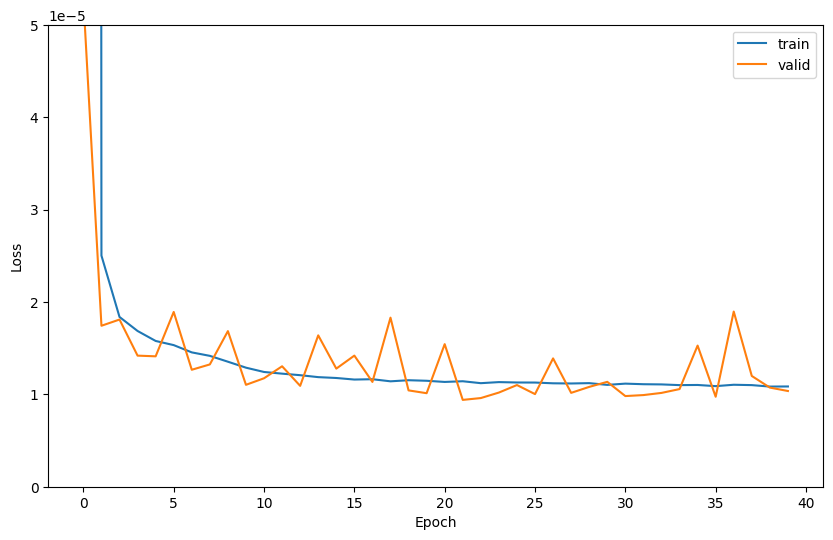

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(train_loss, label='train')
ax.plot(valid_loss, label='valid')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_ylim(0, 5e-5)
ax.legend()
plt.show()

### Evaluate hysteresis prediction

In [6]:
model = LSTMModel(num_layers=1, hidden_size=29)
model.load_state_dict(torch.load('./final/lstm.pth'))
model = model.cuda()
model.eval()

LSTMModel(
  (lstm): LSTM(6, 29, batch_first=True)
  (linear): Linear(in_features=29, out_features=1, bias=True)
)

In [7]:
model.eval()

test_preds = model(torch.tensor(X_test.values, dtype=torch.float32).cuda()).cpu().detach().numpy()

mae = np.mean(np.abs(test_preds - y_test.values))

print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.0026707609157892685


In [16]:
if os.path.exists(r'..\dat\predictions\random_walk_180min.csv'):
    results = preprocess_data(pd.read_csv(r'..\dat\predictions\random_walk_180min.csv'))
else:
    results = test_data.copy()

results['lstm'] = test_preds

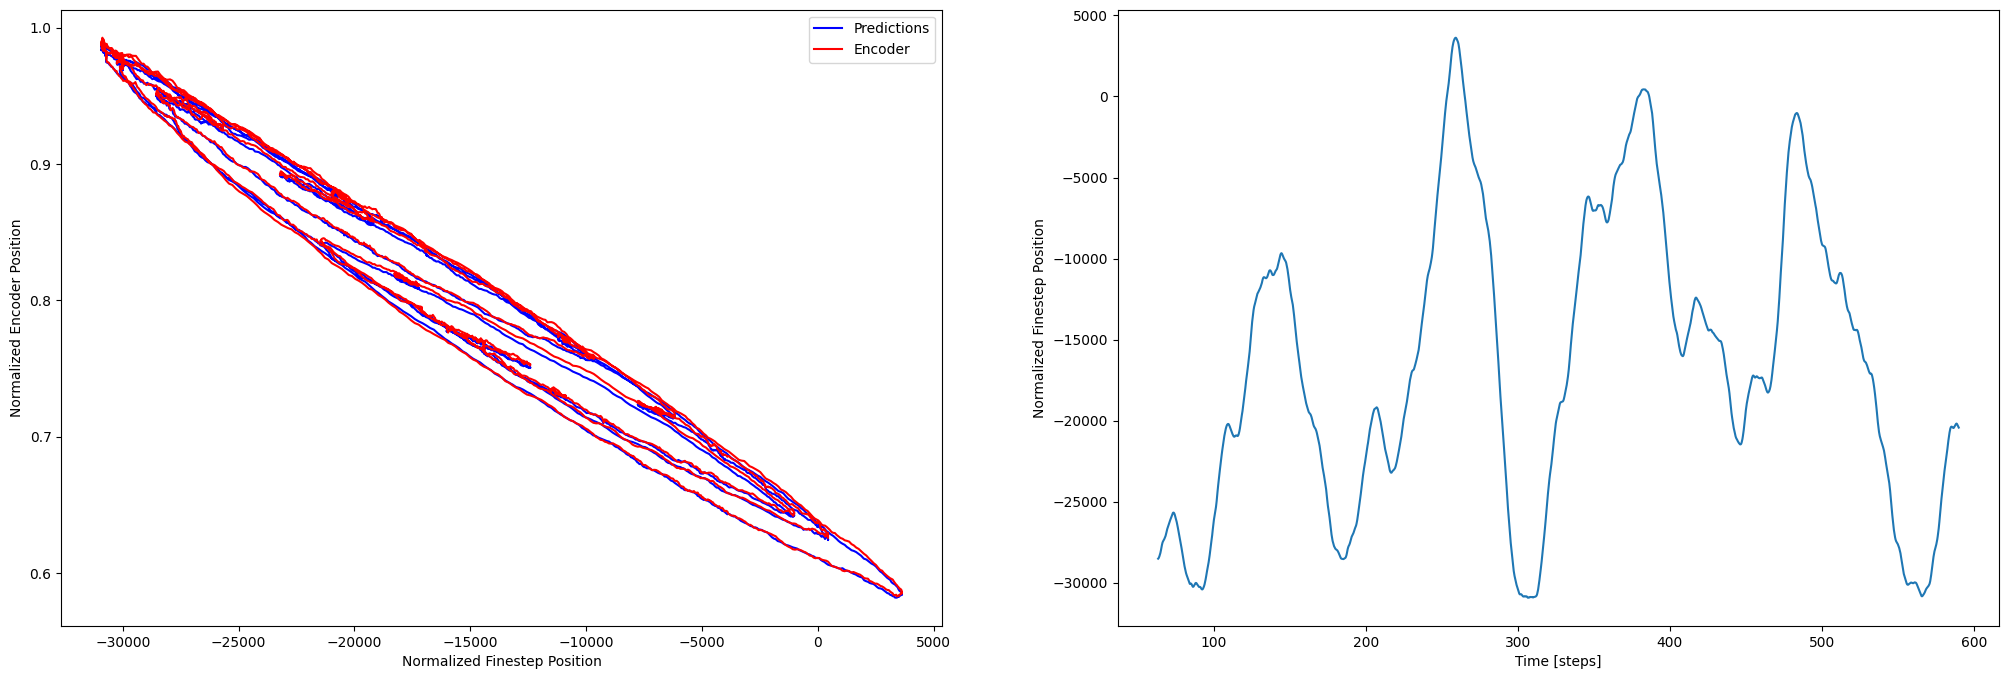

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(25, 8))
max_samples = 5000
#ax[0].plot(test_df['finestep'], -test_df['c_mean'].rolling(8, center=True).mean())
ax[0].plot(test_data[:max_samples]['finestep'], test_preds[:max_samples], label='Predictions', color='blue')
ax[0].plot(test_data[:max_samples]['finestep'], test_data[:max_samples]['c_mean_norm'].rolling(8, center=True).mean(), color='red', label='Encoder')
ax[0].legend()
ax[0].set_xlabel('Normalized Finestep Position')
ax[0].set_ylabel('Normalized Encoder Position')
# mark the start and end of the walk
#ax[0].plot(test_df['finestep'].iloc[0], -test_df['c_mean'].iloc[0], 'ro')
#ax[0].plot(test_df['finestep'].iloc[-1], -test_df['c_mean'].iloc[-1], 'ro')
#ax[0].set_xlim(-np.power(2, 15), np.power(2, 15))
#ax[0].set_ylim(max(outputs), min(outputs) - 0.2)

ax[1].plot(test_data[:max_samples]['time'], test_data[:max_samples]['finestep'])
ax[1].set_xlabel('Time [steps]')
ax[1].set_ylabel('Normalized Finestep Position')
#ax[1].set_ylim(-np.power(2, 15), np.power(2, 15))

plt.show()

#### Evaluate Creep

In [8]:
columns_input

['finestep_norm',
 'step_diff',
 'step_60rsum_exp',
 'step_300rsum_exp',
 'c_mean_lag10',
 'c_mean_10rmean']

In [9]:
model.eval()

outputs = []
gt = []
mse = 0
with torch.no_grad():
    for index, row in creep_data.loc[:].iterrows():
        if len(outputs) > 17000:
            #row['c_mean_lag1'] = outputs[-1]
            #row['c_mean_60rmean'] = (row['c_mean_60rmean'] * 60 - row['c_mean_norm'] + outputs[-1]) / 60
            row['c_mean_10rmean'] = (row['c_mean_10rmean'] * 10 - row['c_mean_norm'] + outputs[-1]) / 10
            # if len(outputs) > 17004:
            #     row['c_mean_lag5'] = outputs[-5]
            if len(outputs) > 17009:
                row['c_mean_lag10'] = outputs[-10]
            # if len(outputs) > 17049:
            #     row['c_mean_lag50'] = outputs[-50]

        inputs = torch.tensor(row[columns_input].values, dtype=torch.float32).view(1, -1)
        output = model(inputs.to('cuda'))
        outputs.append(output.to('cpu').item())
        gt.append(row['c_mean_norm'])

mae = np.mean(np.abs(np.array(outputs) - np.array(gt)))
print(f'MAE: {mae}')
mse = np.mean(np.square(np.array(outputs) - np.array(gt)))
print(f'MSE: {mse}')

MAE: nan
MSE: nan


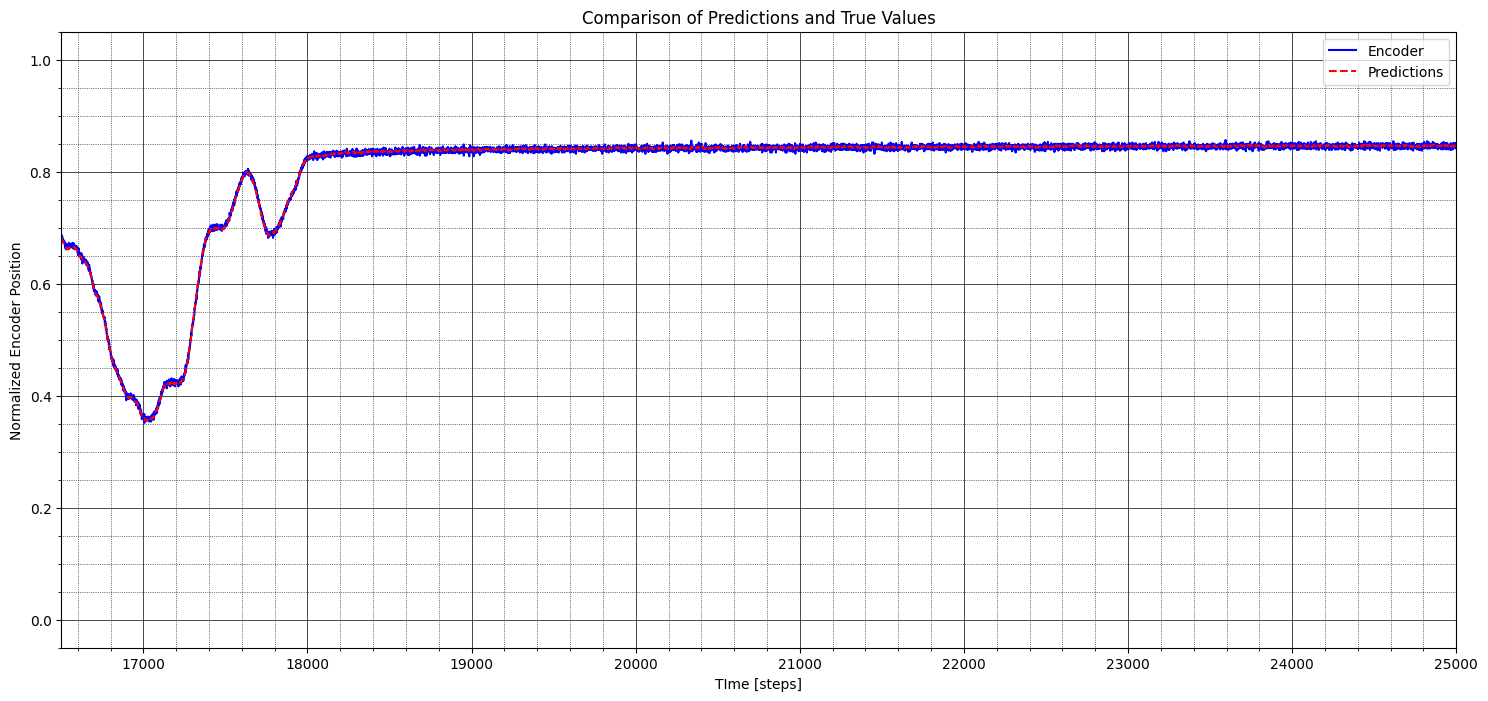

In [21]:
plt.figure(figsize=(18, 8))
plt.plot(gt, label='Encoder', color='blue')
plt.plot(outputs, label='Predictions', color='red', linestyle='dashed')
plt.title('Comparison of Predictions and True Values')
plt.xlabel('TIme [steps]')
plt.ylabel('Normalized Encoder Position')
plt.xlim(16500, 25000)
#plt.ylim(0, 50)
# create grid with minor ticks on y-axis
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

plt.legend()
plt.show()

In [17]:
outputs_unnorm = np.array(outputs) * (creep_data['c_mean_unnorm'].max() - creep_data['c_mean_unnorm'].min()) + creep_data['c_mean_unnorm'].min()
gt_roll = creep_data['c_mean_unnorm'].rolling(window=60).mean()

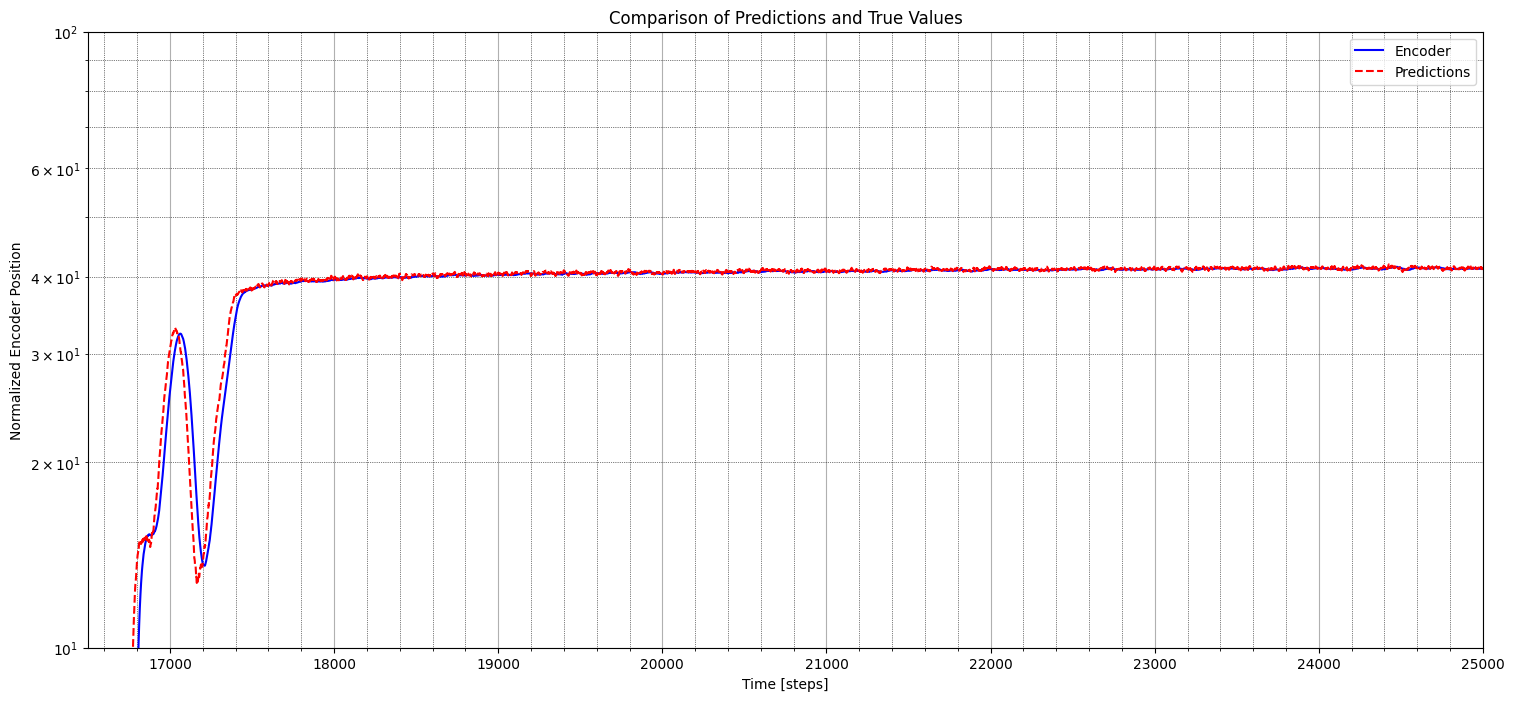

In [19]:
# Plotting the results
plt.figure(figsize=(18, 8))
plt.plot(gt_roll, label='Encoder', color='blue')
plt.plot(outputs_unnorm, label='Predictions', color='red', linestyle='dashed')
plt.title('Comparison of Predictions and True Values')
plt.xlabel('Time [steps]')
plt.ylabel('Normalized Encoder Position')
plt.xlim(16500, 25000)
#plt.ylim(0, 50)
plt.grid()
# add minor ticks every 2
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# make the y axis log scale
plt.yscale('log')
plt.ylim(10, 100)
#plt.grid(which='both')

plt.legend()
plt.show()